### segment waveform into individual syllables using dynamic thresholding
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
import pandas as pd
from datetime import datetime

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings
warnings.filterwarnings(action='once')

In [38]:
from avgn.utils.audio import load_wav, read_wav
from avgn.signalprocessing.filtering import butter_bandpass_filter
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation
from vocalseg.dynamic_thresholding import plot_segmented_spec, plot_segmentations

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [5]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [6]:
DATASET_ID = 'castellucci_mouse_usv'

### Load data in original format

In [7]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-10-07_12-28-32'

### create dataset

In [8]:
hparams = HParams(
    n_fft = 4096,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -100,
    win_length_ms = 4,
    hop_length_ms = 1,
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [9]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/avgn/utils/json.py:64: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/castellucci_mouse_usv/2019-06-23_22-11-52/JSON/VOC597_VOC571_SONG_CMPA_8_25_2016_30_16.56.JSON' mode='r' encoding='UTF-8'>
  return json.load(open(json_loc), object_pairs_hook=OrderedDict)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.5s


[Parallel(n_jobs=-1)]: Done  95 out of 142 | elapsed:   42.3s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:   42.3s finished


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:5605: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/AD/tsainbur/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/ops/signal/util_ops.py:62: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  return ops.convert_to_tensor(fractions.gcd(const_a, const_b))


In [10]:
dataset.sample_json

OrderedDict([('datetime', '2016-08-25_00-00-00'),
             ('samplerate_hz', 250000),
             ('length_s', 180.682752),
             ('wav_loc',
              '/mnt/cube/Datasets/mouse_usv/VOC597/VOC597_VOC571_SONG_CMPA_8_25_2016_30_16.56.WAV'),
             ('age', '30'),
             ('FemaleMouse', 'VOC571'),
             ('call_type', 'SONG'),
             ('weight', '16.56'),
             ('indvs', OrderedDict([('VOC597', OrderedDict())]))])

In [168]:
### segmentation parameters
n_fft=4096
hop_length_ms=2
win_length_ms=4
ref_level_db=25
pre=0.97
min_level_db=-50
min_level_db_floor = -10
db_delta = 5
silence_threshold = 0.05
min_silence_for_spec=0.01
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.01
butter_min = 50000
butter_max = 100000
spectral_range = [50000, 100000]

In [169]:
import librosa

In [170]:
rate, data = load_wav(dataset.sample_json["wav_loc"])

In [171]:
data = data[rate*150:rate*155]

In [172]:
np.min(data), np.max(data)

(-0.0021972656, 0.0026550293)

In [173]:
data = data / np.max(np.abs(data))

In [174]:
# filter data
data = butter_bandpass_filter(data, butter_min, butter_max, rate)

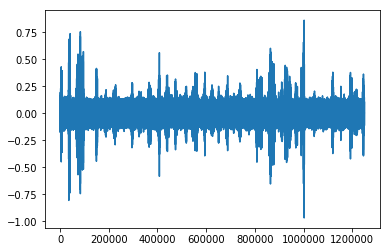

In [175]:
plt.plot(data)

In [176]:
# segment
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    min_level_db_floor=min_level_db_floor,
    db_delta=db_delta,
    ref_level_db=ref_level_db,
    pre=pre,
    min_silence_for_spec=min_silence_for_spec,
    max_vocal_for_spec=max_vocal_for_spec,
    min_level_db=min_level_db,
    silence_threshold=silence_threshold,
    verbose=True,
    min_syllable_length_s=min_syllable_length_s,
    spectral_range=spectral_range,
)

longest silence 0.0
longest vocalization 5.002
Current min_level_db: -50
longest silence 0.0
longest vocalization 5.002
Current min_level_db: -45
longest silence 0.0
longest vocalization 5.002
Current min_level_db: -40
longest silence 0.0
longest vocalization 5.002
Current min_level_db: -35
longest silence 0.0
longest vocalization 5.002
Current min_level_db: -30
longest silence 0.0
longest vocalization 5.002
Current min_level_db: -25
longest silence 0.0
longest vocalization 5.002
Current min_level_db: -20
longest silence 0.03799999999999998
longest vocalization 0.09799999999999986


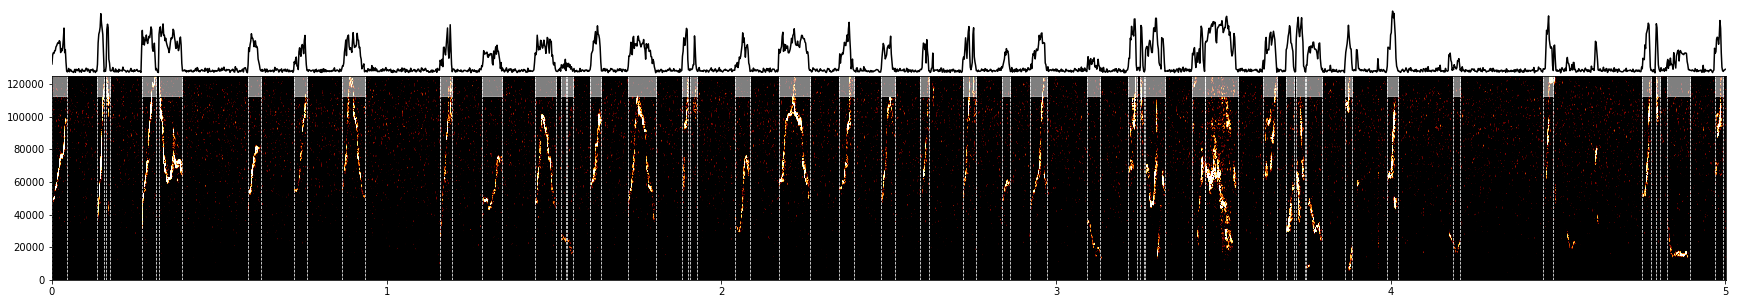

In [177]:
plot_segmentations(
    results["spec"],
    results["vocal_envelope"],
    results["onsets"],
    results["offsets"],
    hop_length_ms,
    rate,
)
plt.show()

### segment and plot 
- for each json, load the wav file - segment the file into start and end times
- plot the segmentation
- add to the JSON 

In [178]:
import joblib

In [179]:
from avgn.utils.json import NoIndent, NoIndentEncoder

In [180]:
??plot_segmentations

In [181]:
warnings.filterwarnings("ignore", message = "'tqdm_notebook' object has no attribute 'sp'")

def segment_spec_custom(key, df, save=False, plot=False):
    # load wav
    rate, data = load_wav(df.data["wav_loc"])
    # filter data
    data = butter_bandpass_filter(data, butter_min, butter_max, rate)

    # segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        min_silence_for_spec=min_silence_for_spec,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=True,
        min_syllable_length_s=min_syllable_length_s,
        spectral_range=spectral_range,
    )
    if results is None:
        return
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
            figsize=(100, 5)
        )
        plt.show()

    # save the results
    json_out = DATA_DIR / "processed" / (DATASET_ID + "_segmented") / DT_ID / "JSON" / (
        key + ".JSON"
    )

    json_dict = df.data.copy()

    json_dict["indvs"][list(df.data["indvs"].keys())[0]]["syllables"] = {
        "start_times": NoIndent(list(results["onsets"])),
        "end_times": NoIndent(list(results["offsets"])),
    }

    json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
    # save json
    if save:
        ensure_dir(json_out.as_posix())
        print(json_txt, file=open(json_out.as_posix(), "w"))

    print(json_txt)

    return results

In [182]:
indvs = np.array(['_'.join(list(i)) for i in dataset.json_indv])
np.unique(indvs)

array(['VOC591', 'VOC592', 'VOC594', 'VOC597'], dtype='<U6')

VOC591


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


/mnt/cube/tsainbur/Projects/github_repos/vocalization_segmentation/vocalseg/dynamic_thresholding.py:129: RuntimeWarning: invalid value encountered in sqrt
  vocal_envelope = np.max(spec, axis=0) * np.sqrt(np.mean(spec, axis=0))


longest silence 3.2560000000000002
longest vocalization 0.09200000000001296


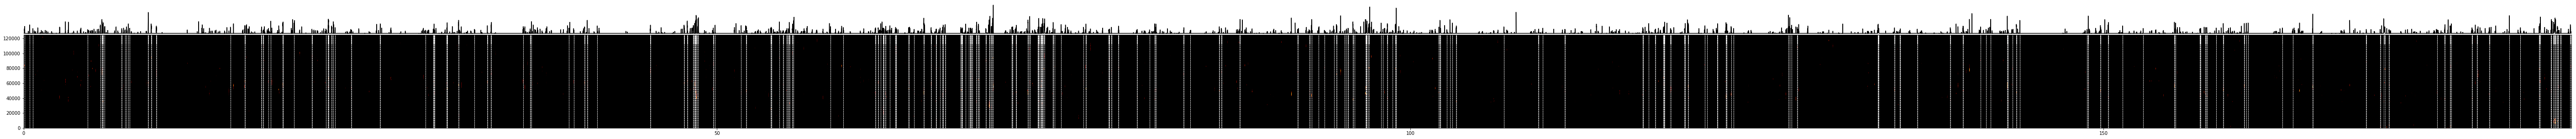

{
  "datetime": "2016-09-10_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 183.730176,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC582_SONG_CMPA_9_10_2016_46_21.23.WAV",
  "age": "46",
  "FemaleMouse": "VOC582",
  "call_type": "SONG",
  "weight": "21.23",
  "indvs": {
    "VOC591": {
      "syllables": {
        "start_times": [0.058, 0.418, 0.656, 4.608, 5.518, 5.632, 5.704, 5.818, 7.06, 7.302, 7.412, 7.528, 7.636, 8.97, 9.18, 9.558, 14.904, 15.928, 17.136, 17.27, 17.648, 17.812, 18.68, 18.698, 19.484, 20.788, 21.784, 21.944, 21.96, 22.186, 22.318, 22.444, 23.616, 25.7, 28.97, 29.53, 29.582, 29.622, 30.506, 30.534, 31.344, 32.494, 33.428, 33.7, 36.022, 36.526, 36.614, 39.31, 39.668, 40.444, 40.622, 41.356, 45.184, 47.62, 47.848, 48.28, 48.382, 48.434, 48.478, 48.614, 49.728, 49.85, 51.736, 52.1, 53.88, 53.94, 54.48, 54.766, 55.038, 55.144, 55.202, 55.426, 55.502, 58.168, 59.092, 61.422, 61.62, 61.798, 61.974, 62.002, 62.146, 62.462, 62.862, 62.9, 62.922, 63.806, 6

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.2s remaining:    0.0s


longest silence 66.534
longest vocalization 0.08400000000000318


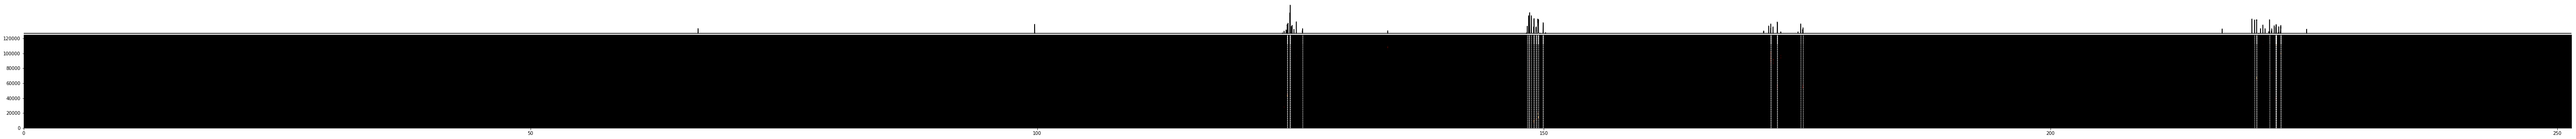

{
  "datetime": "2016-08-01_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 251.396096,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_Isolation_Call_CMPA_8_1_2016_6_2.65.WAV",
  "age": "6",
  "FemaleMouse": "Isolation",
  "call_type": "Call",
  "weight": "2.65",
  "indvs": {
    "VOC591": {
      "syllables": {
        "start_times": [124.67, 124.92, 124.956, 126.178, 148.364, 148.492, 148.598, 148.748, 149.014, 149.226, 149.398, 149.916, 172.374, 173.026, 175.332, 175.564, 220.128, 220.324, 221.6, 222.224, 222.254, 222.702],
        "end_times": [124.696, 124.95, 124.972, 126.192, 148.376, 148.516, 148.61, 148.786, 149.04, 149.248, 149.482, 149.936, 172.4, 173.058, 175.36, 175.578, 220.14, 220.344, 221.61, 222.234, 222.282, 222.728]
      }
    }
  }
}


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.1s remaining:    0.0s


longest silence 4.957999999999998
longest vocalization 0.07600000000000051


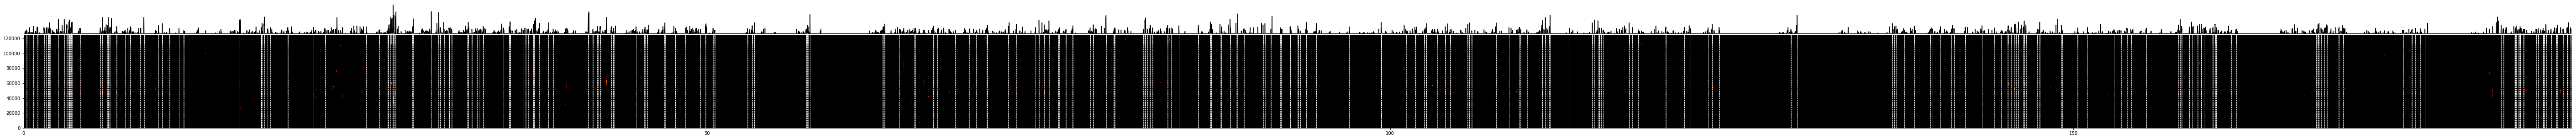

{
  "datetime": "2016-09-11_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 186.44992,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC571_SONG_CMPA_9_11_2016_47_21.34.WAV",
  "age": "47",
  "FemaleMouse": "VOC571",
  "call_type": "SONG",
  "weight": "21.34",
  "indvs": {
    "VOC591": {
      "syllables": {
        "start_times": [0.21, 0.424, 0.698, 1.016, 1.478, 1.63, 1.778, 1.816, 1.828, 1.864, 1.916, 2.53, 2.96, 3.138, 3.288, 3.308, 3.332, 3.422, 3.478, 3.512, 4.15, 5.592, 5.75, 6.122, 6.15, 6.178, 6.28, 6.294, 6.776, 7.422, 7.612, 7.796, 8.524, 8.78, 9.854, 10.138, 10.668, 11.358, 11.708, 15.802, 17.374, 17.386, 17.41, 17.426, 17.582, 17.844, 18.058, 19.316, 21.208, 22.06, 25.066, 26.006, 26.644, 26.674, 26.848, 26.992, 27.024, 27.206, 28.438, 28.472, 28.492, 29.824, 30.344, 30.372, 30.464, 30.504, 30.726, 30.758, 31.12, 31.14, 31.158, 31.306, 32.434, 32.518, 32.794, 33.072, 33.184, 33.314, 33.628, 34.97, 35.108, 35.522, 35.556, 35.596, 36.592, 36.74, 36.9, 37.278

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.2s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 28.701999999999998
longest vocalization 0.034000000000020236


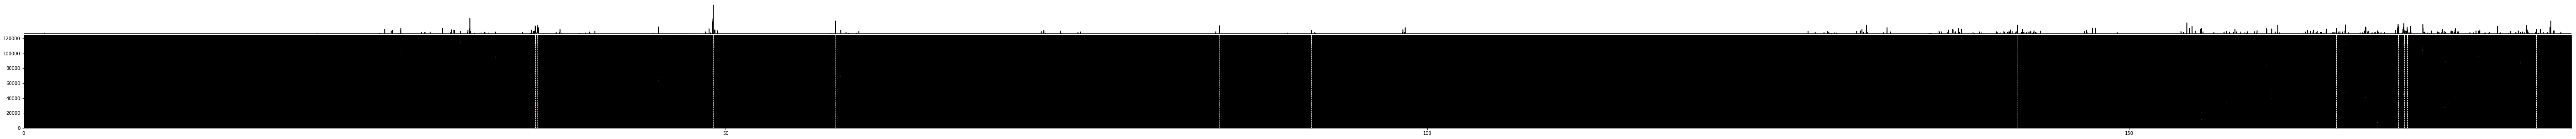

{
  "datetime": "2016-08-25_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 181.501952,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC592/VOC592_VOC575_SONG_CMPA_8_25_2016_30_17.85.WAV",
  "age": "30",
  "FemaleMouse": "VOC575",
  "call_type": "SONG",
  "weight": "17.85",
  "indvs": {
    "VOC592": {
      "syllables": {
        "start_times": [31.766, 36.426, 36.602, 36.618, 49.092, 57.836, 85.182, 91.744, 142.034, 164.742, 169.144, 169.552, 169.798, 179.004],
        "end_times": [31.78, 36.45, 36.614, 36.63, 49.12, 57.848, 85.194, 91.754, 142.044, 164.752, 169.172, 169.586, 169.814, 179.014]
      }
    }
  }
}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s


longest silence 68.112
longest vocalization 0.006000000000000227


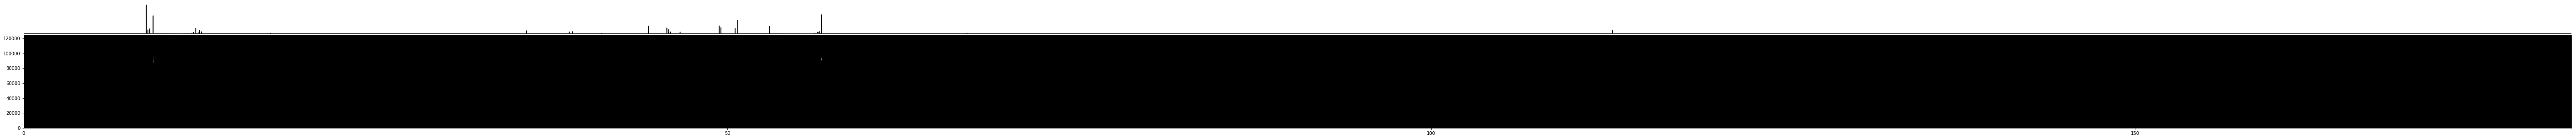

{
  "datetime": "2016-08-16_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 181.010432,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC592/VOC592_VOC574_SONG_CMPA_8_16_2016_21_8.5.WAV",
  "age": "21",
  "FemaleMouse": "VOC574",
  "call_type": "SONG",
  "weight": "8.5",
  "indvs": {
    "VOC592": {
      "syllables": {
        "start_times": [],
        "end_times": []
      }
    }
  }
}


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.3s remaining:    0.0s


longest silence 7.744
longest vocalization 0.08600000000001273


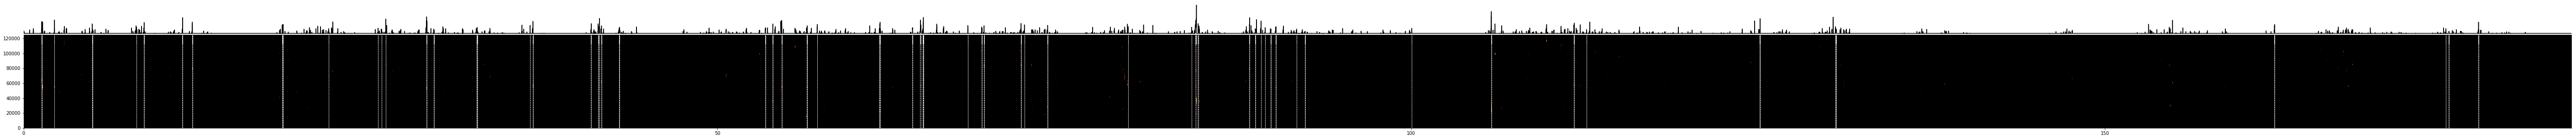

{
  "datetime": "2016-08-30_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 183.631872,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC592/VOC592_VOC576_SONG_CMPA_8_30_2016_35_20.57.WAV",
  "age": "35",
  "FemaleMouse": "VOC576",
  "call_type": "SONG",
  "weight": "20.57",
  "indvs": {
    "VOC592": {
      "syllables": {
        "start_times": [1.282, 1.324, 2.208, 4.926, 4.974, 8.12, 8.672, 11.428, 12.136, 18.634, 18.696, 21.974, 25.532, 25.798, 26.086, 29.032, 29.552, 32.636, 32.676, 36.494, 36.692, 40.89, 41.394, 41.488, 41.64, 42.902, 42.92, 53.454, 53.984, 54.632, 56.45, 56.47, 57.182, 61.676, 61.708, 64.054, 64.616, 64.804, 64.824, 68.042, 69.05, 69.216, 71.882, 72.124, 73.792, 79.606, 84.18, 84.448, 84.654, 88.342, 88.768, 89.184, 89.482, 89.878, 90.244, 91.736, 92.356, 100.048, 105.764, 111.726, 112.642, 125.128, 125.148, 130.582, 130.628, 162.214, 174.586, 174.794, 176.93],
        "end_times": [1.304, 1.334, 2.222, 4.946, 4.986, 8.132, 8.686, 11.462, 12.164, 18.646, 18.71

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   42.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   42.5s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 7.266000000000005
longest vocalization 0.13799999999999812


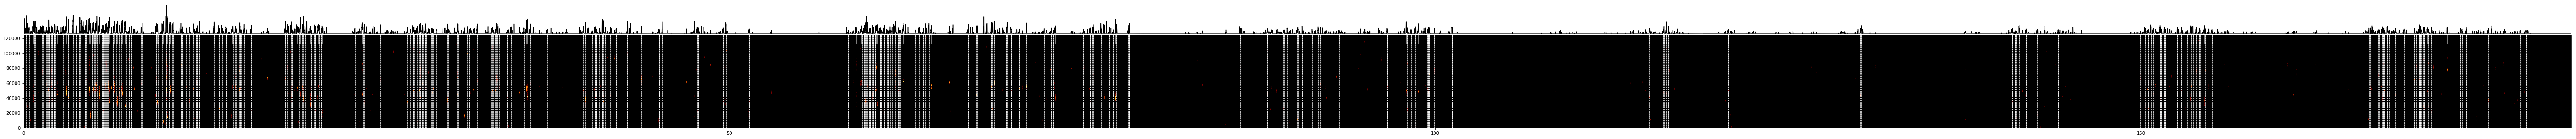

{
  "datetime": "2016-10-13_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 180.486144,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC594/VOC594_VOC649_SONG_CMPA_10_13_2016_79_23.60.WAV",
  "age": "79",
  "FemaleMouse": "VOC649",
  "call_type": "SONG",
  "weight": "23.60",
  "indvs": {
    "VOC594": {
      "syllables": {
        "start_times": [0.06, 0.164, 0.278, 0.364, 0.56, 0.58, 0.65, 0.722, 0.768, 0.9, 1.25, 1.342, 1.574, 1.632, 1.66, 1.76, 1.78, 1.826, 1.95, 2.008, 2.034, 2.154, 2.176, 2.332, 2.382, 2.78, 2.964, 3.144, 3.162, 3.454, 3.708, 3.94, 3.966, 4.1, 4.224, 4.354, 4.446, 4.464, 4.592, 4.626, 4.834, 4.852, 4.894, 5.086, 5.292, 5.518, 5.552, 5.596, 5.644, 5.662, 5.8, 5.84, 5.996, 6.022, 6.342, 6.358, 6.384, 6.554, 6.59, 6.752, 6.93, 7.144, 7.256, 7.468, 7.49, 7.628, 7.866, 8.322, 8.378, 9.352, 9.38, 9.472, 9.488, 9.776, 9.836, 10.066, 10.086, 10.308, 10.34, 10.494, 10.536, 11.136, 11.172, 11.228, 11.522, 11.542, 11.754, 11.994, 12.218, 12.252, 12.28, 12.414, 13.466, 13.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s


longest silence 9.430000000000007
longest vocalization 0.05999999999998806


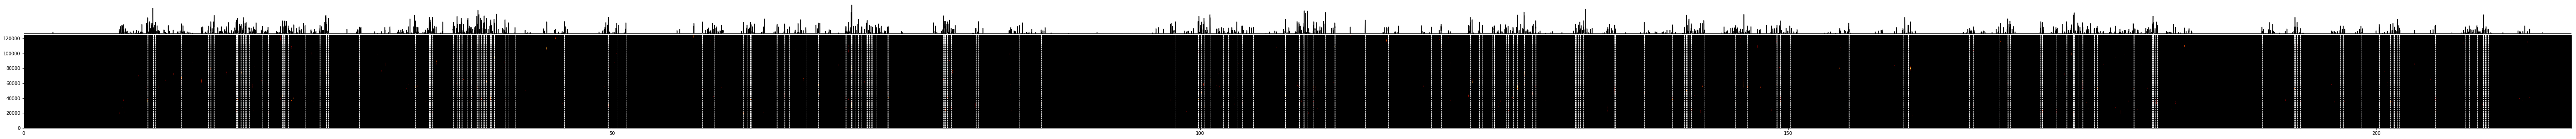

{
  "datetime": "2016-08-20_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 216.563712,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC594/VOC594_VOC571_SONG_CMPA_8_20_2016_25_11.47.WAV",
  "age": "25",
  "FemaleMouse": "VOC571",
  "call_type": "SONG",
  "weight": "11.47",
  "indvs": {
    "VOC594": {
      "syllables": {
        "start_times": [10.526, 10.966, 11.022, 11.198, 13.4, 15.67, 15.884, 16.132, 16.154, 16.502, 18.05, 18.084, 18.124, 18.182, 18.424, 18.642, 18.7, 18.804, 18.89, 19.152, 20.288, 20.768, 21.972, 22.026, 22.052, 22.14, 22.194, 22.34, 22.476, 23.916, 25.17, 25.692, 25.732, 25.876, 28.526, 33.276, 34.452, 34.476, 34.506, 34.54, 34.726, 34.768, 36.5, 36.632, 36.826, 37.02, 37.204, 37.718, 38.018, 38.504, 38.596, 38.686, 38.844, 38.872, 38.92, 39.084, 39.132, 39.324, 39.618, 39.676, 39.974, 40.022, 40.908, 41.206, 41.754, 45.938, 49.634, 49.696, 50.408, 51.182, 57.674, 57.704, 58.718, 61.176, 61.476, 61.754, 61.778, 61.814, 62.976, 64.018, 64.666, 65.072, 66.484, 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.6s remaining:    0.0s


longest silence 3.783999999999992
longest vocalization 0.10000000000000009


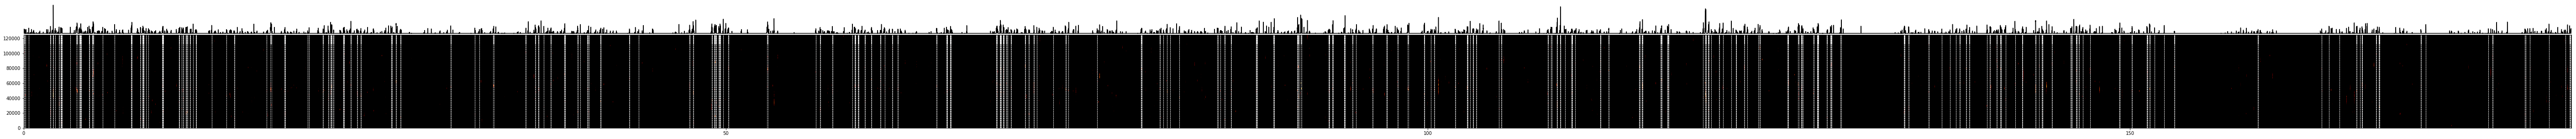

{
  "datetime": "2016-09-11_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 181.436416,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC594/VOC594_VOC580_SONG_CMPA_9_11_2016_47_22.36.WAV",
  "age": "47",
  "FemaleMouse": "VOC580",
  "call_type": "SONG",
  "weight": "22.36",
  "indvs": {
    "VOC594": {
      "syllables": {
        "start_times": [0.026, 0.128, 0.358, 1.898, 2.092, 2.232, 2.514, 2.62, 2.656, 2.686, 2.73, 3.31, 3.734, 3.958, 4.014, 4.052, 4.098, 4.646, 4.672, 4.882, 4.91, 5.622, 6.47, 7.63, 7.676, 8.304, 8.45, 8.484, 8.524, 8.538, 8.704, 8.872, 9.86, 9.894, 9.924, 11.058, 11.086, 11.242, 11.354, 11.556, 11.578, 11.648, 11.85, 12.06, 12.26, 12.284, 13.382, 14.44, 14.998, 17.29, 17.566, 18.576, 18.606, 20.218, 20.318, 21.31, 21.694, 21.854, 21.924, 22.062, 22.758, 22.772, 22.808, 23.296, 23.746, 24.008, 26.162, 26.224, 26.514, 26.84, 30.412, 32.118, 32.454, 33.432, 35.75, 36.412, 36.634, 36.67, 37.036, 37.534, 38.5, 38.522, 38.538, 39.44, 39.64, 40.142, 40.23, 41.078, 41

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.1s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 38.896
longest vocalization 0.04800000000000182


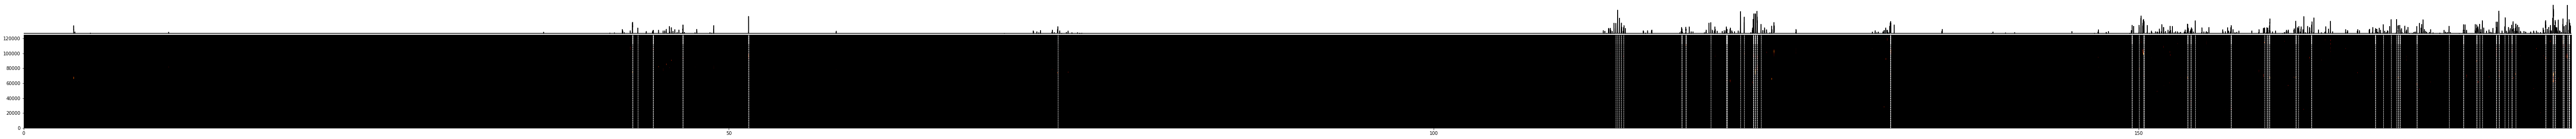

{
  "datetime": "2016-08-25_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 180.682752,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC597/VOC597_VOC571_SONG_CMPA_8_25_2016_30_16.56.WAV",
  "age": "30",
  "FemaleMouse": "VOC571",
  "call_type": "SONG",
  "weight": "16.56",
  "indvs": {
    "VOC597": {
      "syllables": {
        "start_times": [43.16, 43.544, 44.632, 46.74, 51.398, 73.332, 112.902, 113.028, 113.168, 113.306, 113.462, 117.588, 117.878, 119.644, 120.754, 120.792, 121.74, 122.0, 122.644, 122.666, 122.79, 122.914, 123.204, 132.364, 132.388, 149.512, 150.012, 150.34, 150.366, 153.448, 153.69, 153.994, 156.53, 158.918, 159.072, 159.154, 159.262, 161.114, 161.306, 162.244, 166.778, 167.332, 167.888, 168.274, 168.388, 168.512, 169.714, 171.994, 173.022, 173.962, 174.164, 174.356, 175.352, 175.53, 175.954, 176.218, 176.448, 176.73, 178.846, 179.342, 179.368, 179.532, 180.068, 180.166, 180.388, 180.506, 180.524],
        "end_times": [43.186, 43.554, 44.642, 46.76, 51.414, 7

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s


longest silence 11.849999999999994
longest vocalization 0.12399999999999523


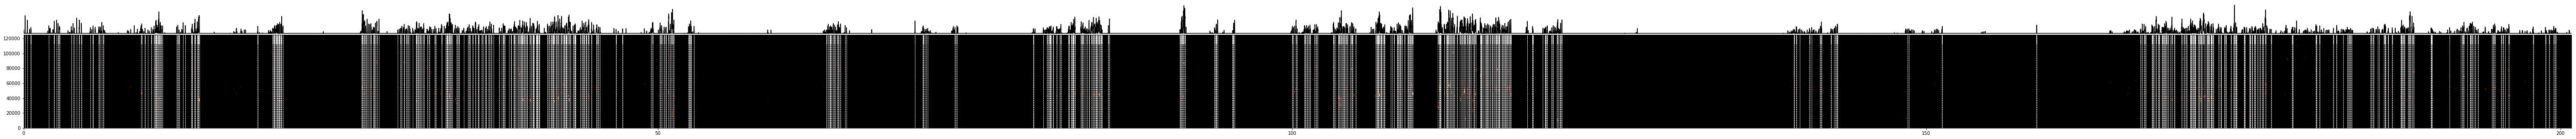

{
  "datetime": "2016-10-19_00-00-00",
  "samplerate_hz": 250000,
  "length_s": 200.86784,
  "wav_loc": "/mnt/cube/Datasets/mouse_usv/VOC597/VOC597_VOC576_SONG_CMPA_10_19_2016_85_23.58.WAV",
  "age": "85",
  "FemaleMouse": "VOC576",
  "call_type": "SONG",
  "weight": "23.58",
  "indvs": {
    "VOC597": {
      "syllables": {
        "start_times": [0.098, 0.272, 0.558, 1.978, 2.388, 2.59, 2.696, 2.814, 3.732, 3.874, 3.982, 4.172, 4.368, 4.544, 5.244, 5.454, 5.47, 5.906, 6.018, 6.146, 6.272, 9.26, 9.554, 9.788, 10.058, 10.274, 10.366, 10.396, 10.452, 10.502, 10.59, 10.626, 10.744, 10.84, 10.934, 12.044, 12.144, 12.248, 12.554, 12.728, 13.228, 13.25, 13.276, 13.458, 13.5, 13.674, 13.768, 13.784, 18.446, 19.632, 19.728, 19.748, 19.774, 19.888, 19.93, 20.0, 20.078, 20.126, 20.146, 20.254, 20.306, 20.432, 26.652, 26.666, 26.78, 26.866, 26.958, 27.064, 27.17, 27.272, 27.37, 27.57, 27.586, 27.628, 27.708, 27.818, 28.012, 29.488, 29.71, 29.814, 29.988, 30.002, 30.184, 30.29, 30.408, 30.674, 30

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.9s remaining:    0.0s


/mnt/cube/tsainbur/Projects/github_repos/vocalization_segmentation/vocalseg/utils.py:16: RuntimeWarning: invalid value encountered in true_divide
  return (x - np.min(x)) / (np.max(x) - np.min(x))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 820 results
  r = func(a, **kwargs)
/mnt/cube/tsainbur/Projects/github_repos/vocalization_segmentation/vocalseg/dynamic_thresholding.py:126: RuntimeWarning: invalid value encountered in less
  spec[spec < 0] = 0
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/mnt/cube/tsainbur/Projects/github_repos/vocalization_segmentation/vocalseg/dynamic_thresholding.py:134: RuntimeWarning: invalid value encountered in greater
  onsets, offsets = onsets_offsets(vocal_envelope > silence_threshold) / fft_

longest silence 0.0
longest vocalization 0.0
Current min_level_db: -50
longest silence 0.0
longest vocalization 0.0
Current min_level_db: -45
longest silence 0.0
longest vocalization 0.0
Current min_level_db: -40
longest silence 0.0
longest vocalization 0.0
Current min_level_db: -35
longest silence 0.0
longest vocalization 0.0
Current min_level_db: -30
longest silence 0.0
longest vocalization 0.0
Current min_level_db: -25
longest silence 0.0
longest vocalization 0.0
Current min_level_db: -20
longest silence 0.0
longest vocalization 0.0
Current min_level_db: -15


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


In [183]:
nex = 3
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

    joblib.Parallel(n_jobs=1, verbose=11)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], plot=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

### Generate for full dataset

In [184]:
nex = -1
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

    joblib.Parallel(n_jobs=-1, verbose=11)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], save=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

VOC591


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done   5 out of  47 | elapsed:  1.1min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  10 out of  47 | elapsed:  1.2min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  15 out of  47 | elapsed:  1.3min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  20 out of  47 | elapsed:  1.5min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  25 out of  47 | elapsed:  1.7min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  30 out of  47 | elapsed:  1.9min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  35 out of  47 | elapsed:  2.0min remaining:   40.5s
[Parallel(n_jobs=-1)]: Done  40 out of  47 | elapsed:  2.1min remaining:   21.7s
[Parallel(n_jobs=-1)]: Done  45 out of  47 | elapsed:  2.2min remaining:    5.7s


VOC592


[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:  2.2min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:   41.5s remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   47.4s remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:   51.4s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:   54.8s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  16 out of  30 | elapsed:   58.1s remaining:   50.8s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.0min remaining:   35.6s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:  1.1min remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed:  1.1min remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  28 out of  30 | elapsed:  1.2min remaining:    5.1s


VOC594


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:   48.1s remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   52.6s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  10 out of  30 | elapsed:   56.0s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:   59.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  16 out of  30 | elapsed:  1.0min remaining:   54.6s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.1min remaining:   37.8s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:  1.1min remaining:   24.8s
[Parallel(n_jobs=-1)]: Done  25 out of  30 | elapsed:  1.2min remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  28 out of  30 | elapsed:  1.2min remaining:    5.3s


VOC597


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done   2 out of  31 | elapsed:   31.1s remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   5 out of  31 | elapsed:   43.5s remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   8 out of  31 | elapsed:   49.8s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  11 out of  31 | elapsed:   54.6s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  14 out of  31 | elapsed:   59.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  17 out of  31 | elapsed:  1.1min remaining:   52.0s
[Parallel(n_jobs=-1)]: Done  20 out of  31 | elapsed:  1.1min remaining:   36.8s
[Parallel(n_jobs=-1)]: Done  23 out of  31 | elapsed:  1.2min remaining:   24.4s
[Parallel(n_jobs=-1)]: Done  26 out of  31 | elapsed:  1.2min remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  29 out of  31 | elapsed:  1.3min remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapse